In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

from stip import read_stip_file, split_descriptors, compute_bovw, build_bovw_dataset


In [2]:
DATASET_PATH = "../data/ucf-sports_dataset/data"
VIDEO_PATH = os.path.join(DATASET_PATH, "videos")
KEYPOINT_PATH = os.path.join(DATASET_PATH, "keypoints")
VOCAB_PATH = "../data/visual_vocabularies"

DESCRIPTOR_TYPE = "hoghof"
VOCAB_SIZE = 500


In [3]:
def load_file_list(file_txt):
    files = []
    with open(file_txt, "r") as f:
        for line in f:
            name, label = line.strip().split()
            key_file = os.path.join(KEYPOINT_PATH, name + ".key")
            files.append((key_file, label))
    return files


file_list = load_file_list(os.path.join(DATASET_PATH, "ucf-sports.files"))
print("Nombre de vidéos :", len(file_list))


Nombre de vidéos : 150


In [4]:
file_list[0]

('../data/ucf-sports_dataset/data/keypoints/Walk-Front_020.key', 'Walk')

## Visualisation des points d’intérêt

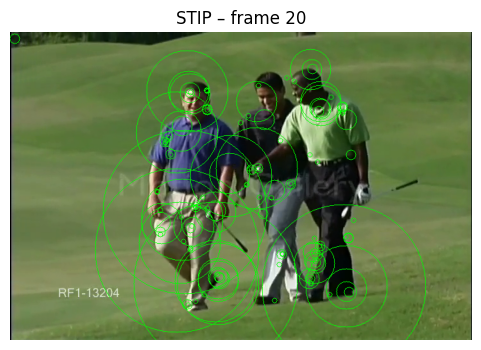

In [5]:
def visualize_stip(video_name, frame_id=0):
    video_file = os.path.join(VIDEO_PATH, video_name + ".avi")
    key_file = os.path.join(KEYPOINT_PATH, video_name + ".key")

    keypoints, _ = read_stip_file(key_file)
    cap = cv2.VideoCapture(video_file)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    ret, frame = cap.read()

    for kp in keypoints:
        y, x, t, scale_xy, _ = kp
        if int(t) == frame_id:
            cv2.circle(frame, (int(x), int(y)),
                       max(1, int(scale_xy)), (0, 255, 0), 1)

    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"STIP – frame {frame_id}")
    plt.axis("off")
    plt.show()


visualize_stip("Walk-Front_020", frame_id=20)


In [14]:
import cv2
import numpy as np
import os

def save_video_with_stip(video_path, keypoints, output_path,
                         color=(0, 255, 0), thickness=1):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*"XVID")

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # dessiner les STIP de cette frame
        for kp in keypoints:
            y, x, t, scale_xy, _ = kp
            if int(t) == frame_id:
                radius = max(1, int(scale_xy))
                cv2.circle(frame, (int(x), int(y)),
                           radius, color, thickness)

        out.write(frame)
        frame_id += 1

    cap.release()
    out.release()
    print("Vidéo enregistrée :", output_path)


In [15]:
video_path = os.path.join(VIDEO_PATH, "Diving-Side_001.avi")
key_path = os.path.join(KEYPOINT_PATH, "Diving-Side_001.key")
output_path = f"Diving-Side_001_stip.avi"
keypoints, _ = read_stip_file(key_path)
save_video_with_stip(video_path, keypoints, output_path)


Vidéo enregistrée : Diving-Side_001_stip.avi


## Classification par sacs de mots visuels spatio-temporels

In [6]:
vocab_file = f"voc_{DESCRIPTOR_TYPE}_{VOCAB_SIZE}.npy"
vocab = np.load(os.path.join(VOCAB_PATH, vocab_file))

print("Vocabulaire chargé :", vocab.shape)

Vocabulaire chargé : (500, 162)


In [7]:
X, y = build_bovw_dataset(file_list, vocab, DESCRIPTOR_TYPE)

print("X shape :", X.shape)
print("y shape :", y.shape)

X shape : (150, 500)
y shape : (150,)


In [8]:
X, y = build_bovw_dataset(file_list, vocab, DESCRIPTOR_TYPE)

print("X shape :", X.shape)
print("y shape :", y.shape)

X shape : (150, 500)
y shape : (150,)


### SVM

In [9]:
loo = LeaveOneOut()
accuracies = []
Classification
for train_idx, test_idx in loo.split(X):
    clf = SVC(kernel="linear")
    clf.fit(X[train_idx], y[train_idx])
    pred = clf.predict(X[test_idx])
    accuracies.append(pred == y[test_idx])

accuracy = np.mean(accuracies)
print("Accuracy :", accuracy)

Accuracy : 0.5666666666666667


In [10]:
results = {}

for desc in ["hog", "hof", "hoghof"]:
    vocab = np.load(os.path.join(VOCAB_PATH, f"voc_{desc}_{VOCAB_SIZE}.npy"))
    X, y = build_bovw_dataset(file_list, vocab, desc)

    accuracies = []
    for train_idx, test_idx in loo.split(X):
        clf = SVC(kernel="linear")
        clf.fit(X[train_idx], y[train_idx])
        pred = clf.predict(X[test_idx])
        accuracies.append(pred == y[test_idx])

    results[desc] = np.mean(accuracies)
    print(desc, ":", results[desc])

hog : 0.6066666666666667
hof : 0.56
hoghof : 0.5666666666666667


## Augmentation de données

In [11]:
aug_file_list = load_file_list(
    os.path.join(DATASET_PATH, "ucf-sports_augmented.files")
)

accuracies = []

for i in range(len(file_list)):
    X_train = []
    y_train = []

    for j, (kf, lab) in enumerate(file_list):
        if j != i:
            X_train.append(X[j])
            y_train.append(lab)
    for kf, lab in aug_file_list:
        X_aug, _ = read_stip_file(kf)
        descriptors = split_descriptors(_, DESCRIPTOR_TYPE)
        bovw = compute_bovw(descriptors, vocab)
        X_train.append(bovw)
        y_train.append(lab)

    clf = SVC(kernel="linear")
    clf.fit(X_train, y_train)

    pred = clf.predict([X[i]])
    accuracies.append(pred == y[i])

print("Accuracy :", np.mean(accuracies))


Accuracy : 0.64
